In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import requests
import orjson 
import pandas as pd 
import polars as pl
from time import sleep

# x = requests.get('https://api.opendota.com/api/publicMatches', params={'less_than_match_id':7075980402})

In [3]:
df = pl.read_parquet('../DATA/tmp_03.11.2023.03.58.04.parquet')
df = df.to_pandas()
df['avg_rank_tier'] = df['avg_rank_tier'].apply(lambda x: x // 10)
df = df[df['avg_rank_tier'] >= 4]
df = pl.from_pandas(df)
DICTS = df.to_dicts()

In [4]:
TEST_DICTS = DICTS[-len(DICTS) // 10:]
TRAIN_DICTS = DICTS[:-len(DICTS) // 10]
len(TRAIN_DICTS), len(TEST_DICTS)

(868039, 96449)

In [5]:
from picker.model.dataset import HeroDataset
from picker.model.constants import HERO_TRANSFORM
from picker.model.training_embs import run_training
from picker.model.word2vec import CBOWModel

train_data = HeroDataset('', dicts_override=TRAIN_DICTS, p=0.0)
test_data = HeroDataset('', dicts_override=TEST_DICTS, p=0.0)

In [6]:
# from torch.nn import CrossEntropyLoss

# model=CBOWModel(emdedding_dim=32)
# run_training(model=model, name='cbow-32-no-unk', train_data=train_data, test_data=test_data, criterion=CrossEntropyLoss(),
#              epochs=50, batch_size=1024 * 4, device='cuda:1')

In [7]:
import torch
model=CBOWModel(emdedding_dim=32)
model.load_state_dict(torch.load(f'cbow-32-no-unk.pth'))

<All keys matched successfully>

In [20]:
from picker.model.mlp import MLPWithEmbeddings
from picker.model.training_model import run_training
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss 

from picker.model.dataset import TeamDataset

train_data2 = TeamDataset('', dicts_override=TRAIN_DICTS, p=0.5)
# test_data2 = TeamDataset('', dicts_override=TRAIN_DICTS[:len(TRAIN_DICTS) // 10], p=0.0)
test_data2 = TeamDataset('', dicts_override=TEST_DICTS, p=0.5)

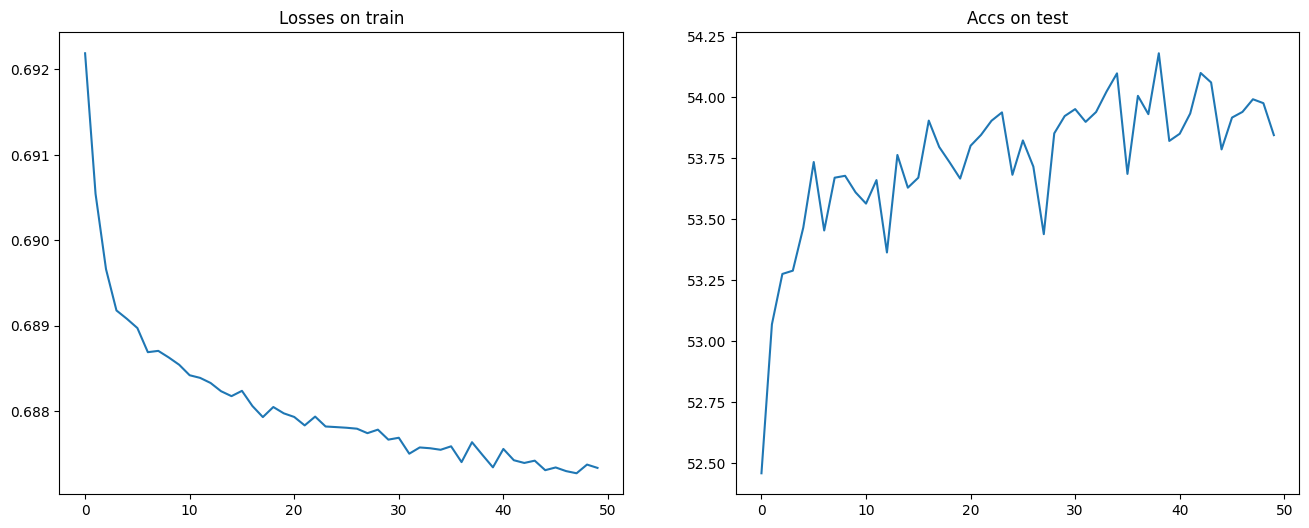

saved model to `mlp-32-0.5-v0.pth`


In [21]:
mlp = MLPWithEmbeddings(model.t_embs)
optimizer = torch.optim.AdamW(mlp.parameters(), lr=3e-4, weight_decay=1e-5)

run_training(model=mlp, name='mlp-32-0.5-v0', optimizer=optimizer, 
             train_data=train_data2,
             test_data=test_data2, criterion=CrossEntropyLoss(),
             epochs=50, batch_size=1024 * 4, device='cuda:1')

In [ ]:
mlp.to('cpu')
torch.softmax(mlp(torch.as_tensor([[0, 0, 0, 0, 0] + [0, 0, 0, 0, 0]])), dim=-1)

In [40]:
torch.softmax(mlp(torch.as_tensor([[0, 0, 0, 0, 0] + [0, 0, 0, 0, 0]])), dim=-1)

tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward0>)